# Flatiron Health aNSCLC: Machine learning models with crude imputation 

**OBJECTIVE: Build 4 survival machine learning models using a crude imputation strategy. This imputation strategy assumes data is missing completely at random and will impute median for numerical variables and leave missing categorical entries as "unknown" (eg., possible ECOG values are 0, 1, 2, 3, 4, 5, and unknown).**

**BACKGROUND: The models were built using scikit-survival which is a machine learning library for survival analysis.  All 4 of these machine learning models are intended for survival analysis and so take into account censored data.** 

**Time-dependent area under the receiver operator curve (AUC) at 1 year from advanced diagnosis was selected as the primary performance metric. This metric determines how well a model can distinguish patients who die by time *t* from patients who die after this time.**

**OUTLINE:**
1. **Preprocessing**
2. **Gradient boosted model** 
3. **Random survival forest** 
4. **Penalized Cox models**
5. **Linear support vector machine** 

## 1. Preprocessing 

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 

### 1.1 Importing full dataframes

In [2]:
# Import training set and set PatientID as index.
train = pd.read_csv('train_full.csv', index_col = 'PatientID')
print(len(train), train.index.is_unique)

54786 True


In [3]:
# Import test set and set PatientID as index.
test = pd.read_csv('test_full.csv', index_col = 'PatientID')
print(len(test), test.index.is_unique)

13697 True


### 1.2 Converting datatypes 

In [4]:
list(train.select_dtypes(include = ['object']).columns)

['PracticeType',
 'gender',
 'race',
 'ethnicity',
 'region',
 'Histology',
 'SmokingStatus',
 'stage',
 'ALK',
 'BRAF',
 'EGFR',
 'KRAS',
 'ROS1',
 'pdl1',
 'pdl1_n',
 'ecog_diagnosis']

In [5]:
to_be_categorical = list(train.select_dtypes(include = ['object']).columns)

In [6]:
# Add adv_year to list of object variables which will be converted to categorical in below cell. 
to_be_categorical.append('adv_year')

In [7]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    train[x] = train[x].astype('category')

In [8]:
list(train.select_dtypes(include = ['category']).columns)

['PracticeType',
 'gender',
 'race',
 'ethnicity',
 'region',
 'Histology',
 'SmokingStatus',
 'stage',
 'adv_year',
 'ALK',
 'BRAF',
 'EGFR',
 'KRAS',
 'ROS1',
 'pdl1',
 'pdl1_n',
 'ecog_diagnosis']

In [9]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    test[x] = test[x].astype('category')

In [10]:
# Convert death_status into True or False (required for scikit-survival). 
train['death_status'] = train['death_status'].astype('bool')

In [11]:
# Convert death_status into True or False (required for scikit-survival).
test['death_status'] = test['death_status'].astype('bool')

### 1.3 Defining validation set 

**A validation dataset will be constructed from the training set. This validation set will comprise of 25% of the training set. It will be used to assist in early stopping for the gradient boosting survival model and the random survival model. Like in the training-test split, a stratified approach will be carried out to preserve the distribution of diagnosis years.**   

In [12]:
train['adv_year_cat'] = pd.cut(train['adv_year'],
                               bins = ['2010', '2012', '2014', '2016', '2018', '2021'],
                               labels = ['11-12', '13-14', '15-16', '17-18', '19-21'])

In [13]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 42)

for sub_train_index, val_index in sss.split(train, train['adv_year_cat']):
    sub_train = train.iloc[sub_train_index]
    val = train.iloc[val_index]

In [14]:
train = train.drop(columns = ['adv_year_cat'])

In [15]:
sub_train = sub_train.drop(columns = ['adv_year_cat'])

In [16]:
val = val.drop(columns = ['adv_year_cat'])

In [17]:
pd.DataFrame(val.index, columns = ['PatientID']).to_csv('val_IDs.csv', index = False, header = True)

In [18]:
val_IDs = pd.read_csv('val_IDs.csv')

### 1.4 Separate into X and Y

In [19]:
# 'X' datasets
train_x = train.drop(columns = ['death_status', 'timerisk_activity']) #80% of data 

test_x = test.drop(columns = ['death_status', 'timerisk_activity']) #20% of data 

sub_train_x = sub_train.drop(columns = ['death_status', 'timerisk_activity']) #60% of data

val_x = val.drop(columns = ['death_status', 'timerisk_activity']) #20% of data 

In [20]:
# 'Y' datasets
# Death status and time until event needs to be stored as a structured array to be compatible with scikit-survival
y_dtypes = train[['death_status', 'timerisk_activity']].dtypes

train_y = np.array([tuple(x) for x in train[['death_status', 'timerisk_activity']].values], 
                   dtype = list(zip(y_dtypes.index, y_dtypes)))

test_y = np.array([tuple(x) for x in test[['death_status', 'timerisk_activity']].values], 
                  dtype = list(zip(y_dtypes.index, y_dtypes)))

sub_train_y = np.array([tuple(x) for x in sub_train[['death_status', 'timerisk_activity']].values],
                       dtype = list(zip(y_dtypes.index, y_dtypes)))

val_y = np.array([tuple(x) for x in val[['death_status', 'timerisk_activity']].values],
                 dtype = list(zip(y_dtypes.index, y_dtypes)))

### 1.5 Build pipeline

In [21]:
list(train_x.select_dtypes(exclude = ['category']).columns)

['age',
 'delta_adv_diagnosis',
 'steroid_diag',
 'opioid_PO_diag',
 'nonopioid_PO_diag',
 'pain_IV_diag',
 'ac_diag',
 'antiinfective_IV_diag',
 'antiinfective_diag',
 'antihyperglycemic_diag',
 'ppi_diag',
 'antidepressant_diag',
 'bta_diag',
 'thyroid_diag',
 'is_diag',
 'commercial',
 'medicare',
 'medicaid',
 'other_insurance',
 'weight_diag',
 'bmi_diag',
 'bmi_diag_na',
 'weight_pct_change',
 'weight_pct_na',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',
 'bun_diag_na',
 'calcium_diag_na',
 'chloride_diag_na',
 'creatinine_diag_na',
 'hemoglobin_diag_na',
 'neutrophil_count_diag_na',
 'platelet_diag_na',
 'potassium_diag_na',
 'sodium_diag_na',
 'tot

In [22]:
# List of numeric variables, excluding binary variables. 
numerical_features = [
    'age',
    'delta_adv_diagnosis',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag', 
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'alp_max',
    'alt_max',
    'ast_max',
    'bicarb_max',
    'bun_max',
    'calcium_max',
    'chloride_max',
    'creatinine_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'alp_min',
    'alt_min',
    'ast_min',
    'bicarb_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'hemoglobin_min',
    'neutrophil_count_min',
    'platelet_min',
    'potassium_min',
    'sodium_min',
    'total_bilirubin_min',
    'wbc_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'icd_count']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [23]:
list(train_x.select_dtypes(include = ['category']).columns)

['PracticeType',
 'gender',
 'race',
 'ethnicity',
 'region',
 'Histology',
 'SmokingStatus',
 'stage',
 'adv_year',
 'ALK',
 'BRAF',
 'EGFR',
 'KRAS',
 'ROS1',
 'pdl1',
 'pdl1_n',
 'ecog_diagnosis']

In [24]:
# List of categorical features.
categorical_features = list(train_x.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [25]:
# Remaining unprocessed columns include binary variables
len(train_x.columns) - (len(numerical_features) + len(categorical_features))

90

In [26]:
all_columns = list(train_x.columns)

In [27]:
# Prints number of columns after removing columns that are numerical or categorical. 
for i in list(numerical_features + categorical_features):
    all_columns.remove(i)
len(all_columns)

90

In [28]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

## 2. Gradient boosting survival model

In [29]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV
from sklearn.pipeline import make_pipeline

from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from joblib import dump, load 

import matplotlib.pyplot as plt

import warnings 

**The gradient boosting survival model will be configured by setting a low learning rate (eg., <= 0.1) and choosing the number of trees by monitoring the 1 year AUC on the valdiation dataset and stopping once performance on the validation dataset begins to degrade. The learning rate will be tuned to achieve a target tree size >500. Once learning rate and tree number are set, a halving grid search with 3-fold cross validation will be performed to identify ideal max depth and subsample percentage.**  

### 2.1 Determining number of trees for full model 

**The full model includes all variables, notably 90 summary labs values which have significant missingness (>40%).**

In [30]:
print(sub_train_x.shape)
print(val_x.shape)

(41089, 210)
(13697, 210)


In [31]:
sub_train_xt = preprocessor.fit_transform(sub_train_x)
val_xt = preprocessor.transform(val_x)

gbm_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                           learning_rate = 0.05,
                                           max_depth = 3,
                                           subsample = 0.75,
                                           verbose = 1,
                                           random_state = 42)

gbm_exp.fit(sub_train_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      208565.2051          32.4486          498.29m
         2      208794.6385          30.9620          498.95m
         3      208900.5214          32.1751          498.21m
         4      208854.9051          30.1561          497.86m
         5      209067.3319          27.5748          497.36m
         6      208348.3329          28.0982          496.86m
         7      208873.3312          26.0178          496.60m
         8      208078.4766          23.8382          496.21m
         9      208263.4282          22.0678          495.77m
        10      208289.2453          22.3027          495.34m
        20      207034.7362          15.9052          492.42m
        30      206752.5173          11.4947          489.05m
        40      207134.8765           9.6838          485.58m
        50      206517.0233           7.3744          482.13m
        60      206497.2149           6.0181          478.75m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [32]:
gbm_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 365)[0][0] 
                  for risk_score in gbm_exp.staged_predict(val_xt)]

In [33]:
gbm_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 365)[0][0] 
                     for risk_score in gbm_exp.staged_predict(sub_train_xt)]

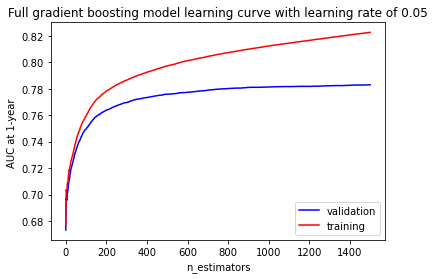

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm_staged_auc))
plt.plot(x, gbm_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 1-year ")
plt.title('Full gradient boosting model learning curve with learning rate of 0.05')

plt.show()

In [35]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm_staged_auc[x:x+24]))

In [36]:
print('Number of trees where 1 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 1 year AUC on validation dataset beings to downgrade: 1125
Validation dataset AUC before degrading: 0.7817657118378613
Training dataset AUC before degrading: 0.8150570276634403


### 2.2 Determining number of trees for sparse model 

**The sparse model includes a subset of the summary lab values that are considered clinically relevant. Performance will be compared to the full model.**

In [37]:
all_labs = [
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'albumin_diag_na',
    'alp_diag_na',
    'alt_diag_na',
    'ast_diag_na',
    'bicarb_diag_na',
    'bun_diag_na',
    'calcium_diag_na',
    'chloride_diag_na',
    'creatinine_diag_na',
    'hemoglobin_diag_na',
    'neutrophil_count_diag_na',
    'platelet_diag_na',
    'potassium_diag_na',
    'sodium_diag_na',
    'total_bilirubin_diag_na',
    'wbc_diag_na',
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'alp_max',
    'alt_max',
    'ast_max',
    'bicarb_max',
    'bun_max',
    'calcium_max',
    'chloride_max',
    'creatinine_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'alp_min',
    'alt_min',
    'ast_min',
    'bicarb_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'hemoglobin_min',
    'neutrophil_count_min',
    'platelet_min',
    'potassium_min',
    'sodium_min',
    'total_bilirubin_min',
    'wbc_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [38]:
keep_labs = [
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'albumin_diag_na',
    'alp_diag_na',
    'alt_diag_na',
    'ast_diag_na',
    'bicarb_diag_na',
    'bun_diag_na',
    'calcium_diag_na',
    'chloride_diag_na',
    'creatinine_diag_na',
    'hemoglobin_diag_na',
    'neutrophil_count_diag_na',
    'platelet_diag_na',
    'potassium_diag_na',
    'sodium_diag_na',
    'total_bilirubin_diag_na',
    'wbc_diag_na',
    'alp_max',
    'alt_max',
    'ast_max',
    'calcium_max',
    'creatinine_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min']

In [39]:
drop_labs = [
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'bicarb_max',
    'bun_max',
    'chloride_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'alp_min',
    'alt_min',
    'ast_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'neutrophil_count_min',
    'potassium_min',
    'total_bilirubin_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [40]:
len(keep_labs) + len(drop_labs) == len(all_labs)

True

In [41]:
sub_train_x_red = sub_train_x.drop(columns = drop_labs)
val_x_red = val_x.drop(columns = drop_labs)

In [42]:
print(sub_train_x.shape)
print(sub_train_x_red.shape)
print(val_x.shape)
print(val_x_red.shape)

(41089, 210)
(41089, 127)
(13697, 210)
(13697, 127)


In [43]:
sub_train_x_red.loc[:, 'alp_max_na'] = np.where(sub_train_x_red['alp_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'alt_max_na'] = np.where(sub_train_x_red['alt_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'ast_max_na'] = np.where(sub_train_x_red['ast_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'calcium_max_na'] = np.where(sub_train_x_red['calcium_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'creatinine_max_na'] = np.where(sub_train_x_red['creatinine_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(sub_train_x_red['total_bilirubin_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'wbc_max_na'] = np.where(sub_train_x_red['wbc_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'albumin_min_na'] = np.where(sub_train_x_red['albumin_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'bicarb_min_na'] = np.where(sub_train_x_red['bicarb_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'hemoglobin_min_na'] = np.where(sub_train_x_red['hemoglobin_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'platelet_min_na'] = np.where(sub_train_x_red['platelet_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'sodium_min_na'] = np.where(sub_train_x_red['sodium_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'wbc_min_na'] = np.where(sub_train_x_red['wbc_min'].isna(), 1, 0)

In [44]:
val_x_red.loc[:, 'alp_max_na'] = np.where(val_x_red['alp_max'].isna(), 1, 0)
val_x_red.loc[:, 'alt_max_na'] = np.where(val_x_red['alt_max'].isna(), 1, 0)
val_x_red.loc[:, 'ast_max_na'] = np.where(val_x_red['ast_max'].isna(), 1, 0)
val_x_red.loc[:, 'calcium_max_na'] = np.where(val_x_red['calcium_max'].isna(), 1, 0)
val_x_red.loc[:, 'creatinine_max_na'] = np.where(val_x_red['creatinine_max'].isna(), 1, 0)
val_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(val_x_red['total_bilirubin_max'].isna(), 1, 0)
val_x_red.loc[:, 'wbc_max_na'] = np.where(val_x_red['wbc_max'].isna(), 1, 0)
val_x_red.loc[:, 'albumin_min_na'] = np.where(val_x_red['albumin_min'].isna(), 1, 0)
val_x_red.loc[:, 'bicarb_min_na'] = np.where(val_x_red['bicarb_min'].isna(), 1, 0)
val_x_red.loc[:, 'hemoglobin_min_na'] = np.where(val_x_red['hemoglobin_min'].isna(), 1, 0)
val_x_red.loc[:, 'platelet_min_na'] = np.where(val_x_red['platelet_min'].isna(), 1, 0)
val_x_red.loc[:, 'sodium_min_na'] = np.where(val_x_red['sodium_min'].isna(), 1, 0)
val_x_red.loc[:, 'wbc_min_na'] = np.where(val_x_red['wbc_min'].isna(), 1, 0)

In [45]:
# List of numeric variables, excluding binary variables. 
numerical_features_red = [
    'age',
    'delta_adv_diagnosis',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'alp_max',
    'alt_max',
    'ast_max',
    'calcium_max',
    'creatinine_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min',
    'icd_count']

# Transformer will impute column medians and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [46]:
preprocessor_red = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features_red),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [47]:
print(sub_train_x_red.shape)
print(sub_train_y.shape)
print(val_x_red.shape)
print(val_y.shape)

(41089, 140)
(41089,)
(13697, 140)
(13697,)


In [48]:
list(sub_train_x_red.columns)

['PracticeType',
 'gender',
 'race',
 'ethnicity',
 'age',
 'region',
 'Histology',
 'SmokingStatus',
 'stage',
 'adv_year',
 'delta_adv_diagnosis',
 'steroid_diag',
 'opioid_PO_diag',
 'nonopioid_PO_diag',
 'pain_IV_diag',
 'ac_diag',
 'antiinfective_IV_diag',
 'antiinfective_diag',
 'antihyperglycemic_diag',
 'ppi_diag',
 'antidepressant_diag',
 'bta_diag',
 'thyroid_diag',
 'is_diag',
 'ALK',
 'BRAF',
 'EGFR',
 'KRAS',
 'ROS1',
 'pdl1',
 'pdl1_n',
 'commercial',
 'medicare',
 'medicaid',
 'other_insurance',
 'ecog_diagnosis',
 'weight_diag',
 'bmi_diag',
 'bmi_diag_na',
 'weight_pct_change',
 'weight_pct_na',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',

In [49]:
sub_train_xt_red = preprocessor_red.fit_transform(sub_train_x_red)
val_xt_red = preprocessor_red.transform(val_x_red)

gbm_exp2 = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                           learning_rate = 0.05,
                                           max_depth = 3,
                                           subsample = 0.75,
                                           verbose = 1,
                                           random_state = 42)

gbm_exp2.fit(sub_train_xt_red, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      208565.8420          34.3303          496.49m
         2      208795.5642          30.7579          498.11m
         3      208901.2937          31.7237          497.73m
         4      208856.7110          29.7326          497.07m
         5      209068.8401          28.5139          496.49m
         6      208350.4263          27.5346          495.97m
         7      208876.3562          26.5964          495.88m
         8      208080.4282          23.5778          495.43m
         9      208268.3260          22.5249          495.38m
        10      208293.4179          24.1108          494.93m
        20      207035.8445          15.9054          491.13m
        30      206755.5262          11.7527          487.78m
        40      207143.6961           9.7981          484.66m
        50      206522.7435           7.9061          481.34m
        60      206512.8143           6.1942          478.09m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [50]:
gbm2_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 365)[0][0] for 
                   risk_score in gbm_exp2.staged_predict(val_xt_red)]

In [51]:
gbm2_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 365)[0][0] for 
                      risk_score in gbm_exp2.staged_predict(sub_train_xt_red)]

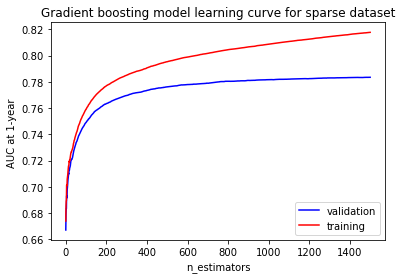

In [52]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm2_staged_auc))
plt.plot(x, gbm2_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm2_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 1-year ")
plt.title('Gradient boosting model learning curve for sparse dataset')

plt.show()

In [53]:
# Average AUC for every 25 additional trees. 
mean2_auc_list = []
for x in np.arange(0, len(gbm2_staged_auc), 25):
    mean2_auc_list.append(np.mean(gbm2_staged_auc[x:x+24]))

In [54]:
print('Number of trees where 1 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean2_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm2_staged_auc[np.where(np.diff(mean2_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm2_staged_auc_tr[np.where(np.diff(mean2_auc_list) < 0)[0][0]*25])

Number of trees where 1 year AUC on validation dataset beings to downgrade: 1425
Validation dataset AUC before degrading: 0.7834668381319828
Training dataset AUC before degrading: 0.8167228765980818


**Performance of the sparse model appears about equivalent to the full model in regards to discriminatory performance on the validation set. The advantages of using the sparse model include less risk of overfitting of training set, faster computational speed, and improved interpretability of feature importance. In addition, there might be improved imputations of missing values with MICE. For these reasons, we'll plan to proceed with the sparse model.**

### 2.3 Further tuning of tree hyperparameters

**Tree depth and subsample will be tuned using a halving grid search with 3-fold cross validation. The other main tree hyperparameter is the minimum sample size in a terminal node (ie., leaf), but since we're using short trees it's unlikely to have significant impact on performance and so we'll omit from the parameter search to save computing time.** 

**A traditional cartesian grid search is not feasible for the gradient boosting model with our dataset given how computationally expensive they are to build. Instead, a halving grid search will be performed which is much faster than a traditional cartesian grid search. The major drawback of the halving grid search is that good configurations that are slow to converge at the beginning will be pruned prematurely so you can’t be entirely ensure that you’ve identified the best hyperparameters. Patients that meet criteria for the 90-day gap are used in the search given more stable distributions of survival times.**

In [55]:
train_x_red = train_x.drop(columns = drop_labs)

In [56]:
train_x_red.loc[:, 'alp_max_na'] = np.where(train_x_red['alp_max'].isna(), 1, 0)
train_x_red.loc[:, 'alt_max_na'] = np.where(train_x_red['alt_max'].isna(), 1, 0)
train_x_red.loc[:, 'ast_max_na'] = np.where(train_x_red['ast_max'].isna(), 1, 0)
train_x_red.loc[:, 'calcium_max_na'] = np.where(train_x_red['calcium_max'].isna(), 1, 0)
train_x_red.loc[:, 'creatinine_max_na'] = np.where(train_x_red['creatinine_max'].isna(), 1, 0)
train_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(train_x_red['total_bilirubin_max'].isna(), 1, 0)
train_x_red.loc[:, 'wbc_max_na'] = np.where(train_x_red['wbc_max'].isna(), 1, 0)
train_x_red.loc[:, 'albumin_min_na'] = np.where(train_x_red['albumin_min'].isna(), 1, 0)
train_x_red.loc[:, 'bicarb_min_na'] = np.where(train_x_red['bicarb_min'].isna(), 1, 0)
train_x_red.loc[:, 'hemoglobin_min_na'] = np.where(train_x_red['hemoglobin_min'].isna(), 1, 0)
train_x_red.loc[:, 'platelet_min_na'] = np.where(train_x_red['platelet_min'].isna(), 1, 0)
train_x_red.loc[:, 'sodium_min_na'] = np.where(train_x_red['sodium_min'].isna(), 1, 0)
train_x_red.loc[:, 'wbc_min_na'] = np.where(train_x_red['wbc_min'].isna(), 1, 0)

In [57]:
train_x_red.shape

(54786, 140)

In [58]:
train_y.shape

(54786,)

In [59]:
# Find all pipe item unique keys 
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean2_auc_list) < 0)[0][0]*25,
                                                                        learning_rate = 0.05,
                                                                        random_state = 42))

estimator = as_cumulative_dynamic_auc_scorer(pipe, times = [365])

sorted(estimator.get_params().keys())

['estimator',
 'estimator__columntransformer',
 'estimator__columntransformer__cat',
 'estimator__columntransformer__cat__categories',
 'estimator__columntransformer__cat__drop',
 'estimator__columntransformer__cat__dtype',
 'estimator__columntransformer__cat__handle_unknown',
 'estimator__columntransformer__cat__sparse',
 'estimator__columntransformer__n_jobs',
 'estimator__columntransformer__num',
 'estimator__columntransformer__num__imputer',
 'estimator__columntransformer__num__imputer__add_indicator',
 'estimator__columntransformer__num__imputer__copy',
 'estimator__columntransformer__num__imputer__fill_value',
 'estimator__columntransformer__num__imputer__missing_values',
 'estimator__columntransformer__num__imputer__strategy',
 'estimator__columntransformer__num__imputer__verbose',
 'estimator__columntransformer__num__memory',
 'estimator__columntransformer__num__std_scaler',
 'estimator__columntransformer__num__std_scaler__copy',
 'estimator__columntransformer__num__std_scaler_

In [60]:
gap90_IDs = pd.read_csv('gap90_IDs.csv')

In [61]:
train90 = train[train.index.isin(gap90_IDs['PatientID'])]

In [62]:
train90_x_red = train_x_red[train_x_red.index.isin(gap90_IDs['PatientID'])]

In [63]:
train90_y = np.array([tuple(x) for x in train90[['death_status', 'timerisk_activity']].values], 
                   dtype = list(zip(y_dtypes.index, y_dtypes)))

In [64]:
train90_x_red.shape

(49095, 140)

In [65]:
train90_y.shape

(49095,)

In [66]:
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 1425,
                                                                        learning_rate = 0.05,
                                                                        random_state = 42))

warnings.filterwarnings('ignore')

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__gradientboostingsurvivalanalysis__max_depth': [2, 3, 4], 
              'estimator__gradientboostingsurvivalanalysis__subsample': [0.5, 0.75, 0.9]}

gbm_search = HalvingGridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 365),
    param_grid,
    cv = cv,
    factor = 2,
    resource = 'n_samples',
    max_resources = 30000,
    return_train_score = False,
    refit = False,
    verbose = 1,
    random_state = 42,
    n_jobs = -1)

# Run search
gbm_search.fit(train90_x_red, train90_y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 3750
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 3750
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 5
n_resources: 7500
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 3
n_resources: 15000
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 30000
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sksurv/metrics.py", line 795, in score
    **self._get_score_params(),
  File "/Applications/anaconda3/lib/python3.7/site-packages/sksurv/metrics.py", line 466, in cumulative_dynamic_auc
    ipcw = cens.predict_ipcw(survival_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sksurv/nonparametric.py", line 445, in predict_ipcw
    Ghat = se

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('num',
                                                                                                                           Pipeline(steps=[('imputer',
                                                                                                                                            SimpleImputer(strategy='median')),
                                                                                                                                           ('std_scaler',
                                                               

In [67]:
gbm_search.best_params_

{'estimator__gradientboostingsurvivalanalysis__max_depth': 2,
 'estimator__gradientboostingsurvivalanalysis__subsample': 0.75}

### 2.4 Building and evaluating final model 

In [68]:
test_x_red = test_x.drop(columns = drop_labs)

In [69]:
test_x_red.loc[:, 'alp_max_na'] = np.where(test_x_red['alp_max'].isna(), 1, 0)
test_x_red.loc[:, 'alt_max_na'] = np.where(test_x_red['alt_max'].isna(), 1, 0)
test_x_red.loc[:, 'ast_max_na'] = np.where(test_x_red['ast_max'].isna(), 1, 0)
test_x_red.loc[:, 'calcium_max_na'] = np.where(test_x_red['calcium_max'].isna(), 1, 0)
test_x_red.loc[:, 'creatinine_max_na'] = np.where(test_x_red['creatinine_max'].isna(), 1, 0)
test_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(test_x_red['total_bilirubin_max'].isna(), 1, 0)
test_x_red.loc[:, 'wbc_max_na'] = np.where(test_x_red['wbc_max'].isna(), 1, 0)
test_x_red.loc[:, 'albumin_min_na'] = np.where(test_x_red['albumin_min'].isna(), 1, 0)
test_x_red.loc[:, 'bicarb_min_na'] = np.where(test_x_red['bicarb_min'].isna(), 1, 0)
test_x_red.loc[:, 'hemoglobin_min_na'] = np.where(test_x_red['hemoglobin_min'].isna(), 1, 0)
test_x_red.loc[:, 'platelet_min_na'] = np.where(test_x_red['platelet_min'].isna(), 1, 0)
test_x_red.loc[:, 'sodium_min_na'] = np.where(test_x_red['sodium_min'].isna(), 1, 0)
test_x_red.loc[:, 'wbc_min_na'] = np.where(test_x_red['wbc_min'].isna(), 1, 0)

In [70]:
test_x_red.shape

(13697, 140)

In [71]:
gbm_crude = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 1425,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 2,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_crude.fit(train_x_red, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      286857.1106          37.7982          834.02m
         2      287228.6502          35.7491          830.20m
         3      287234.4924          32.0929          834.60m
         4      287022.0469          34.0250          832.60m
         5      286884.3804          30.0560          830.60m
         6      285936.2690          30.0314          829.08m
         7      286525.2915          26.4745          828.16m
         8      286157.8421          27.1070          826.95m
         9      286876.1477          25.5154          826.03m
        10      286390.4608          23.9852          825.56m
        20      285609.5233          16.0913          818.41m
        30      285569.0830          11.8151          812.00m
        40      285177.3184           9.4000          806.25m
        50      284467.6271           7.6351          801.55m
        60      283970.6836           6.8511          796.61m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [72]:
gbm_risk_scores_te = gbm_crude.predict(test_x_red)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 365)[0][0]
print('Test set AUC at 1 year:', gbm_auc_te)

Test set AUC at 1 year: 0.787442654421658


In [73]:
gbm_risk_scores_tr = gbm_crude.predict(train_x_red)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 365)[0][0]
print('Training set AUC at 1 year:', gbm_auc_tr)

Training set AUC at 1 year: 0.7934495669814188


In [74]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 365)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [75]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004128065899577501


In [76]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 365)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [77]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0020305924319970843


In [78]:
crude_auc_data = {'model': ['gbm_crude'],
                  'auc_1yr_te': [gbm_auc_te],
                  'sem_te': [standard_error_te],
                  'auc_1yr_tr': [gbm_auc_tr],
                  'sem_tr': [standard_error_tr]}

crude_auc_df = pd.DataFrame(crude_auc_data)

In [79]:
crude_auc_df

,model,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,gbm_crude,0.787443,0.004128,0.79345,0.002031


In [80]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [81]:
times = np.arange(30, 1810, 30)
crude_gbm_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = crude_gbm_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_auc_over5 = pd.DataFrame(times_data, index = ['gbm_crude'])

In [82]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.828087,0.837199,0.828516,0.822428,0.819805,0.812663,0.805503,0.801027,0.794772,0.791386,...,0.754921,0.755207,0.755186,0.753519,0.754502,0.755006,0.757776,0.757342,0.755963,0.760696


In [83]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [84]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 192
Number of non-zero features in final model: 138


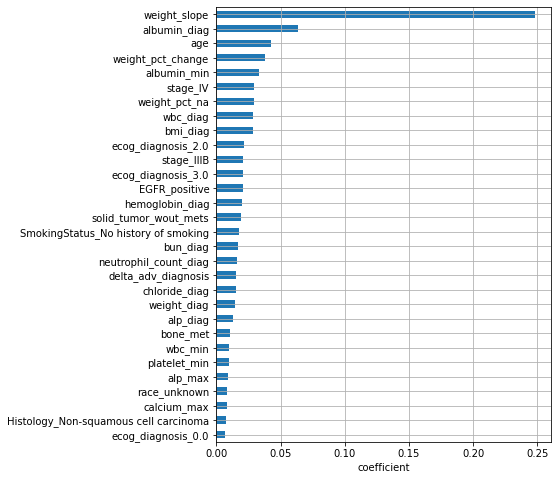

In [85]:
# Dataframe of coefficients for each variable 
coefficients_gbm = pd.DataFrame(
    gbm_crude.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_gbm.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_gbm.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

## 3 Random survival forest model

In [86]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingRandomSearchCV
from sklearn.pipeline import make_pipeline

from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from sksurv.ensemble import RandomSurvivalForest

import warnings 

**Similar to the gradient boosting survival model, the random survival model will first be configured by determining ideal number of trees using early stopping. Unlike the gradient boosting survival model, however, the testing performance of the test set does not decrease with additional trees (ie., overfitting), so the main consideration is ensuring sufficiently high number of trees to achieve optimal test performance while minimzing computational time (ie., not building unnecessary number of trees). Once the ideal tree number is identified, a halving grid search with 3-fold cross validation will be performed to tune hyperparameters, though random forest models typically have excellent out-of-the-box performance so tuning will be cursory.**  

### 3.1 Number of trees 

In [87]:
# Create function that adds tree one at a time, calculates AUC at 1-yr on validation set, 
# and breaks once validation AUC decreases 5 times in a row

rsf = RandomSurvivalForest(min_samples_leaf = 10,
                           max_features = 0.333,
                           warm_start = True,
                           verbose = 0,
                           random_state = 42)

sub_train_xt_red = preprocessor_red.fit_transform(sub_train_x_red)
val_xt_red = preprocessor_red.transform(val_x_red)

max_yr_auc = 0
error_going_up = 0

for n_estimators in range(1, 1000): 
    rsf.n_estimators = n_estimators
    rsf.fit(sub_train_xt_red, sub_train_y)
    
    rsf_chf_funcs = rsf.predict_cumulative_hazard_function(val_xt_red)
    rsf_risk_scores = np.row_stack([chf(365) for chf in rsf_chf_funcs])
    rsf_yr_auc = cumulative_dynamic_auc(sub_train_y, val_y, rsf_risk_scores, 365)[0][0]
    
    if rsf_yr_auc > max_yr_auc:
        max_yr_auc = rsf_yr_auc
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [88]:
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(val_xt_red)
rsf_risk_scores = np.row_stack([chf(365) for chf in rsf_chf_funcs])
rsf_yr_auc = cumulative_dynamic_auc(sub_train_y, val_y, rsf_risk_scores, 365)[0][0]

print('Ideal number of trees:', rsf.n_estimators)
print('Validation set AUC at 1 year with ideal tree number:', round(rsf_yr_auc, 5))

Ideal number of trees: 78
Validation set AUC at 1 year with ideal tree number: 0.76515


### 3.2 Hyperparameter tuning 

**About 100 trees will likely be enough to achieve optimal AUC performance. Next, we'll perform a grid search to tune hyperparameters. The hyperparamter with the largest impact on performance other than tree number is the number of features considered at any given split (ie., max_features). (Side note: if the number of features considered at each split includes all features (ie., max_features = 1) then the algrorithm will be equivalent to bagging decision trees.) Tree complexity, specifically number of samples in leaf nodes, will also be tuned in the grid search, though its impact on performance is likely marginal in comparison to number of trees or number of features considered at each split.** 

In [89]:
# Find all pipe item unique keys 
pipe = make_pipeline(preprocessor_red, RandomSurvivalForest(n_estimators = 100,
                                                            verbose = 0,
                                                            random_state = 42))

estimator = as_cumulative_dynamic_auc_scorer(pipe, times = [365])

sorted(estimator.get_params().keys())

['estimator',
 'estimator__columntransformer',
 'estimator__columntransformer__cat',
 'estimator__columntransformer__cat__categories',
 'estimator__columntransformer__cat__drop',
 'estimator__columntransformer__cat__dtype',
 'estimator__columntransformer__cat__handle_unknown',
 'estimator__columntransformer__cat__sparse',
 'estimator__columntransformer__n_jobs',
 'estimator__columntransformer__num',
 'estimator__columntransformer__num__imputer',
 'estimator__columntransformer__num__imputer__add_indicator',
 'estimator__columntransformer__num__imputer__copy',
 'estimator__columntransformer__num__imputer__fill_value',
 'estimator__columntransformer__num__imputer__missing_values',
 'estimator__columntransformer__num__imputer__strategy',
 'estimator__columntransformer__num__imputer__verbose',
 'estimator__columntransformer__num__memory',
 'estimator__columntransformer__num__std_scaler',
 'estimator__columntransformer__num__std_scaler__copy',
 'estimator__columntransformer__num__std_scaler_

In [90]:
pipe = make_pipeline(preprocessor_red, RandomSurvivalForest(n_estimators = 100,
                                                            verbose = 0,
                                                            random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__randomsurvivalforest__max_features': [0.1, 0.333, 0.5, 0.75, 0.9], 
              'estimator__randomsurvivalforest__min_samples_leaf': [5, 10, 15]}

rsf_search = HalvingRandomSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 365),
    param_distributions = param_grid,
    cv = cv,
    factor = 3,
    resource = 'n_samples',
    min_resources = 3000,
    return_train_score = False,
    refit = False,
    verbose = 1,
    random_state = 42,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
rsf_search.fit(train90_x_red, train90_y)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 3000
max_resources_: 49095
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 15
n_resources: 3000
Fitting 3 folds for each of 15 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 5
n_resources: 9000
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 2
n_resources: 27000
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sksurv/metrics.py", line 795, in score
    **self._get_score_params(),
  File "/Applications/anaconda3/lib/python3.7/site-packages/sksurv/metrics.py", line 466, in cumulative_dynamic_auc
    ipcw = cens.predict_ipcw(survival_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sksurv/nonparametric.py", line 445, in predict_ipcw
    Ghat = se

HalvingRandomSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                      estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                            ColumnTransformer(remainder='passthrough',
                                                                                                              transformers=[('num',
                                                                                                                             Pipeline(steps=[('imputer',
                                                                                                                                              SimpleImputer(strategy='median')),
                                                                                                                                             ('std_scaler',
                                                 

In [91]:
rsf_search.best_params_

{'estimator__randomsurvivalforest__min_samples_leaf': 10,
 'estimator__randomsurvivalforest__max_features': 0.5}

### 3.3 Building model and assessing performance

In [92]:
rsf = make_pipeline(preprocessor_red, RandomSurvivalForest(n_estimators = 100,
                                                           max_features = 0.5, 
                                                           min_samples_leaf = 10,
                                                           n_jobs = -1,
                                                           verbose = 0,
                                                           random_state = 42))

rsf.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [93]:
rsf_chf_funcs_te = rsf.predict_cumulative_hazard_function(test_x_red)
rsf_risk_scores_te = np.row_stack([chf(365) for chf in rsf_chf_funcs_te])
rsf_auc_te = cumulative_dynamic_auc(train_y, test_y, rsf_risk_scores_te, 365)[0][0]
print('Test set AUC at 1 year:', rsf_auc_te)

Test set AUC at 1 year: 0.7745935405691607


In [94]:
rsf_risk_scores_tr = rsf.predict(train_x_red)
rsf_auc_tr = cumulative_dynamic_auc(train_y, train_y, rsf_risk_scores_tr, 365)[0][0]
print('Training set AUC at 1 year:', rsf_auc_tr)

Training set AUC at 1 year: 0.9010286981938638


In [95]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(rsf_risk_scores_te), len(rsf_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], rsf_risk_scores_te[indices], 365)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [96]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.0042136359808451615


In [97]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(rsf_risk_scores_tr), len(rsf_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], rsf_risk_scores_tr[indices], 365)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [98]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0013518894082216206


In [99]:
crude_auc_data = {'model': 'rsf_crude',
                  'auc_1yr_te': rsf_auc_te,
                  'sem_te': standard_error_te,
                  'auc_1yr_tr': rsf_auc_tr,
                  'sem_tr': standard_error_tr}

In [100]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [101]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [102]:
crude_auc_df

,model,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,gbm_crude,0.787443,0.004128,0.793450,0.002031
1,rsf_crude,0.774594,0.004214,0.901029,0.001352


In [103]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [104]:
times = np.arange(30, 1810, 30)

rsf_chf_funcs_te = rsf.predict_cumulative_hazard_function(test_x_red)
rsf_risk_scores_te = np.row_stack([chf(times) for chf in rsf_chf_funcs_te])
crude_rsf_auc_over5 = cumulative_dynamic_auc(train_y, test_y, rsf_risk_scores_te, times)[0]

times_data = {}
values = crude_rsf_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_rsf_over5_df = pd.DataFrame(times_data, index = ['rsf_crude'])

In [105]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [106]:
crude_auc_over5 = crude_auc_over5.append(crude_rsf_over5_df, ignore_index = False)

In [107]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.828087,0.837199,0.828516,0.822428,0.819805,0.812663,0.805503,0.801027,0.794772,0.791386,...,0.754921,0.755207,0.755186,0.753519,0.754502,0.755006,0.757776,0.757342,0.755963,0.760696
rsf_crude,0.867312,0.859772,0.835875,0.820824,0.812596,0.802378,0.794869,0.789264,0.781928,0.778615,...,0.749314,0.749701,0.748179,0.744339,0.745877,0.746235,0.748660,0.747506,0.745445,0.751312


In [108]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

**No feature importance attribute is available at this time for the random survival forest model.**

**The gradient survival model outperforms the random survival forest in regards to test set 1 year AUC.**

## 4. Penalized Cox models 

**The next group of models we'll build is the penalized Cox variety which includes ridge, LASSO, and elastic net. The main challenge will be selecting the strength of the alpha penalty for each model. The penalty will be determined by performing a grid search with cross-validation.**

In [109]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

import warnings 

import matplotlib.pyplot as plt

### 4.1 Ridge

In [110]:
pipe = make_pipeline(preprocessor_red, CoxPHSurvivalAnalysis())

# 5 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__coxphsurvivalanalysis__alpha': 10. ** np.linspace(-4, 4, 25)}

ridge_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 365),
    param_grid = param_grid,
    cv = cv,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
ridge_search.fit(train90_x_red, train90_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                                                

In [111]:
ridge_search.best_params_

{'estimator__coxphsurvivalanalysis__alpha': 0.0001}

In [112]:
best_ridge_alpha = ridge_search.best_params_.get('estimator__coxphsurvivalanalysis__alpha')

In [113]:
ridge = make_pipeline(preprocessor_red, CoxPHSurvivalAnalysis(alpha = best_ridge_alpha))

ridge.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [114]:
ridge_risk_scores_te = ridge.predict(test_x_red)
ridge_auc_te = cumulative_dynamic_auc(train_y, test_y, ridge_risk_scores_te, 365)[0][0]
print('Test set AUC at 1 year:', ridge_auc_te)

Test set AUC at 1 year: 0.7517937018856802


In [115]:
ridge_risk_scores_tr = ridge.predict(train_x_red)
ridge_auc_tr = cumulative_dynamic_auc(train_y, train_y, ridge_risk_scores_tr, 365)[0][0]
print('Training set AUC at 1 year:', ridge_auc_tr)

Training set AUC at 1 year: 0.7552879179286013


In [116]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(ridge_risk_scores_te), len(ridge_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], ridge_risk_scores_te[indices], 365)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [117]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004429870818889374


In [118]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(ridge_risk_scores_tr), len(ridge_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], ridge_risk_scores_tr[indices], 365)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [119]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.00216505005146261


In [120]:
crude_auc_data = {'model': 'ridge_crude',
                  'auc_1yr_te': ridge_auc_te,
                  'sem_te': standard_error_te,
                  'auc_1yr_tr': ridge_auc_tr,
                  'sem_tr': standard_error_tr}

In [121]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [122]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [123]:
crude_auc_df

,model,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,gbm_crude,0.787443,0.004128,0.793450,0.002031
1,rsf_crude,0.774594,0.004214,0.901029,0.001352
2,ridge_crude,0.751794,0.004430,0.755288,0.002165


In [124]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [125]:
times = np.arange(30, 1810, 30)
crude_ridge_auc_over5 = cumulative_dynamic_auc(train_y, test_y, ridge_risk_scores_te, times)[0]

times_data = {}
values = crude_ridge_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_ridge_over5_df = pd.DataFrame(times_data, index = ['ridge_crude'])

In [126]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [127]:
crude_auc_over5 = crude_auc_over5.append(crude_ridge_over5_df, ignore_index = False)

In [128]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.828087,0.837199,0.828516,0.822428,0.819805,0.812663,0.805503,0.801027,0.794772,0.791386,...,0.754921,0.755207,0.755186,0.753519,0.754502,0.755006,0.757776,0.757342,0.755963,0.760696
rsf_crude,0.867312,0.859772,0.835875,0.820824,0.812596,0.802378,0.794869,0.789264,0.781928,0.778615,...,0.749314,0.749701,0.748179,0.744339,0.745877,0.746235,0.748660,0.747506,0.745445,0.751312
ridge_crude,0.777286,0.780309,0.769720,0.763561,0.762762,0.760119,0.758587,0.756088,0.753052,0.752842,...,0.731014,0.730098,0.729564,0.728929,0.731563,0.731050,0.730840,0.729901,0.726485,0.729286


In [129]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [130]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 192
Number of non-zero features in final model: 192


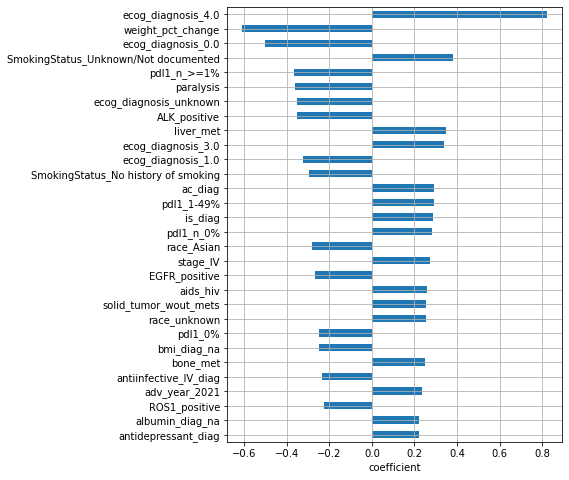

In [131]:
# Dataframe of coefficients for each variable 
coefficients_ridge = pd.DataFrame(
    ridge.named_steps['coxphsurvivalanalysis'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_ridge.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_ridge.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

### 4.2 LASSO

In [132]:
lasso = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 1.0, alpha_min_ratio = 0.0001))

lasso.fit(train90_x_red, train90_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [133]:
lasso.named_steps['coxnetsurvivalanalysis'].alphas_

array([1.73947525e-01, 1.58494506e-01, 1.44414291e-01, 1.31584923e-01,
       1.19895282e-01, 1.09244115e-01, 9.95391690e-02, 9.06963836e-02,
       8.26391669e-02, 7.52977310e-02, 6.86084881e-02, 6.25134991e-02,
       5.69599722e-02, 5.18998052e-02, 4.72891696e-02, 4.30881301e-02,
       3.92602994e-02, 3.57725226e-02, 3.25945903e-02, 2.96989767e-02,
       2.70606015e-02, 2.46566122e-02, 2.24661867e-02, 2.04703526e-02,
       1.86518229e-02, 1.69948464e-02, 1.54850711e-02, 1.41094200e-02,
       1.28559780e-02, 1.17138884e-02, 1.06732588e-02, 9.72507593e-03,
       8.86112699e-03, 8.07392889e-03, 7.35666330e-03, 6.70311761e-03,
       6.10763111e-03, 5.56504600e-03, 5.07066265e-03, 4.62019896e-03,
       4.20975321e-03, 3.83577034e-03, 3.49501108e-03, 3.18452392e-03,
       2.90161960e-03, 2.64384771e-03, 2.40897556e-03, 2.19496881e-03,
       1.99997383e-03, 1.82230167e-03, 1.66041341e-03, 1.51290686e-03,
       1.37850439e-03, 1.25604186e-03, 1.14445856e-03, 1.04278802e-03,
      

In [134]:
estimated_alphas = lasso.named_steps['coxnetsurvivalanalysis'].alphas_

In [135]:
pipe = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 1.0, max_iter = 100000))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__coxnetsurvivalanalysis__alphas': [[x] for x in estimated_alphas]}

lasso_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 365),
    param_grid = param_grid,
    cv = cv,
    error_score = 0.5,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
lasso_search.fit(train90_x_red, train90_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                  

In [136]:
lasso_search.best_params_

{'estimator__coxnetsurvivalanalysis__alphas': [0.007356663298116748]}

In [137]:
best_lasso_alpha = lasso_search.best_params_.get('estimator__coxnetsurvivalanalysis__alphas')

In [138]:
lasso = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 1.0, 
                                                               alphas = best_lasso_alpha,
                                                               max_iter = 100000))

lasso.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [139]:
lasso_risk_scores_te = lasso.predict(test_x_red)
lasso_auc_te = cumulative_dynamic_auc(train_y, test_y, lasso_risk_scores_te, 365)[0][0]
print('Test set AUC at 1 year:', lasso_auc_te)

Test set AUC at 1 year: 0.7361069862399987


In [140]:
lasso_risk_scores_tr = lasso.predict(train_x_red)
lasso_auc_tr = cumulative_dynamic_auc(train_y, train_y, lasso_risk_scores_tr, 365)[0][0]
print('Training set AUC at 1 year:', lasso_auc_tr)

Training set AUC at 1 year: 0.7374363401419076


In [141]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

warnings.filterwarnings('ignore')

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(lasso_risk_scores_te), len(lasso_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], lasso_risk_scores_te[indices], 365)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [142]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004536355907505022


In [143]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

warnings.filterwarnings('ignore')

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(lasso_risk_scores_tr), len(lasso_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], lasso_risk_scores_tr[indices], 365)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [144]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.002254758528593879


In [145]:
crude_auc_data = {'model': 'lasso_crude',
                  'auc_1yr_te': lasso_auc_te,
                  'sem_te': standard_error_te,
                  'auc_1yr_tr': lasso_auc_tr,
                  'sem_tr': standard_error_tr}

In [146]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [147]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [148]:
crude_auc_df

,model,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,gbm_crude,0.787443,0.004128,0.793450,0.002031
1,rsf_crude,0.774594,0.004214,0.901029,0.001352
2,ridge_crude,0.751794,0.004430,0.755288,0.002165
3,lasso_crude,0.736107,0.004536,0.737436,0.002255


In [149]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [150]:
times = np.arange(30, 1810, 30)
crude_lasso_auc_over5 = cumulative_dynamic_auc(train_y, test_y, lasso_risk_scores_te, times)[0]

times_data = {}
values = crude_lasso_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_lasso_over5_df = pd.DataFrame(times_data, index = ['lasso_crude'])

In [151]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [152]:
crude_auc_over5 = crude_auc_over5.append(crude_lasso_over5_df, ignore_index = False)

In [153]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.828087,0.837199,0.828516,0.822428,0.819805,0.812663,0.805503,0.801027,0.794772,0.791386,...,0.754921,0.755207,0.755186,0.753519,0.754502,0.755006,0.757776,0.757342,0.755963,0.760696
rsf_crude,0.867312,0.859772,0.835875,0.820824,0.812596,0.802378,0.794869,0.789264,0.781928,0.778615,...,0.749314,0.749701,0.748179,0.744339,0.745877,0.746235,0.748660,0.747506,0.745445,0.751312
ridge_crude,0.777286,0.780309,0.769720,0.763561,0.762762,0.760119,0.758587,0.756088,0.753052,0.752842,...,0.731014,0.730098,0.729564,0.728929,0.731563,0.731050,0.730840,0.729901,0.726485,0.729286
lasso_crude,0.768503,0.769596,0.761076,0.753053,0.750823,0.747141,0.744786,0.741996,0.737649,0.737079,...,0.741010,0.740091,0.739450,0.740001,0.742917,0.743656,0.744641,0.743439,0.738617,0.743433


In [154]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [155]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 192
Number of non-zero features in final model: 51


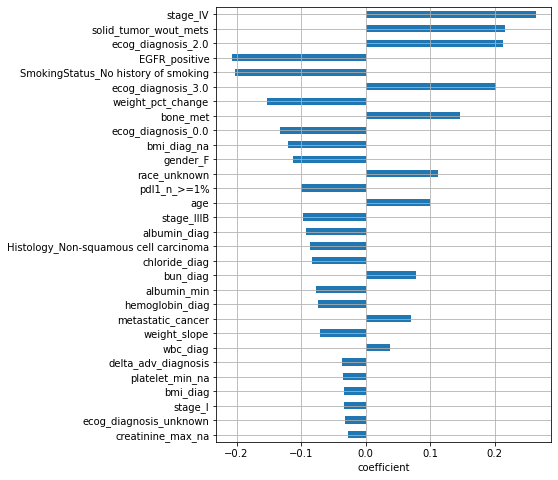

In [156]:
# Dataframe of coefficients for each variable 
coefficients_lasso = pd.DataFrame(
    lasso.named_steps['coxnetsurvivalanalysis'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_lasso.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_lasso.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

### 4.3 Elastic net 

In [157]:
enet = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 0.9, alpha_min_ratio = 0.0001))

enet.fit(train90_x_red, train90_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [158]:
enet.named_steps['coxnetsurvivalanalysis'].alphas_

array([1.93275028e-01, 1.76105007e-01, 1.60460323e-01, 1.46205470e-01,
       1.33216979e-01, 1.21382350e-01, 1.10599077e-01, 1.00773760e-01,
       9.18212965e-02, 8.36641456e-02, 7.62316535e-02, 6.94594435e-02,
       6.32888580e-02, 5.76664503e-02, 5.25435218e-02, 4.78757001e-02,
       4.36225549e-02, 3.97472473e-02, 3.62162114e-02, 3.29988630e-02,
       3.00673350e-02, 2.73962358e-02, 2.49624297e-02, 2.27448363e-02,
       2.07242477e-02, 1.88831626e-02, 1.72056345e-02, 1.56771334e-02,
       1.42844200e-02, 1.30154315e-02, 1.18591765e-02, 1.08056399e-02,
       9.84569665e-03, 8.97103210e-03, 8.17407033e-03, 7.44790845e-03,
       6.78625679e-03, 6.18338444e-03, 5.63406961e-03, 5.13355439e-03,
       4.67750357e-03, 4.26196705e-03, 3.88334564e-03, 3.53835992e-03,
       3.22402177e-03, 2.93760856e-03, 2.67663952e-03, 2.43885424e-03,
       2.22219315e-03, 2.02477963e-03, 1.84490379e-03, 1.68100762e-03,
       1.53167154e-03, 1.39560206e-03, 1.27162062e-03, 1.15865335e-03,
      

In [159]:
estimated_alphas = enet.named_steps['coxnetsurvivalanalysis'].alphas_

In [160]:
pipe = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 0.9, max_iter = 100000))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__coxnetsurvivalanalysis__alphas': [[x] for x in estimated_alphas]}

enet_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 365),
    param_grid = param_grid,
    cv = cv,
    error_score = 0.5,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
enet_search.fit(train90_x_red, train90_y)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0.5. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/A

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                  

In [161]:
enet_search.best_params_

{'estimator__coxnetsurvivalanalysis__alphas': [0.008174070331240827]}

In [162]:
best_enet_alpha = enet_search.best_params_.get('estimator__coxnetsurvivalanalysis__alphas')

In [163]:
enet = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 0.9,
                                                              alphas = best_enet_alpha,
                                                              max_iter = 100000))

enet.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [164]:
enet_risk_scores_te = enet.predict(test_x_red)
enet_auc_te = cumulative_dynamic_auc(train_y, test_y, enet_risk_scores_te, 365)[0][0]
print('Test set AUC at 1 year:', enet_auc_te)

Test set AUC at 1 year: 0.7357884077467685


In [165]:
enet_risk_scores_tr = enet.predict(train_x_red)
enet_auc_tr = cumulative_dynamic_auc(train_y, train_y, enet_risk_scores_tr, 365)[0][0]
print('Training set AUC at 1 year:', enet_auc_tr)

Training set AUC at 1 year: 0.7371631017877147


In [166]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

warnings.filterwarnings('ignore')

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(enet_risk_scores_te), len(enet_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], enet_risk_scores_te[indices], 365)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [167]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004540251052351145


In [168]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

warnings.filterwarnings('ignore')

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(enet_risk_scores_tr), len(enet_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], enet_risk_scores_tr[indices], 365)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [169]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.002255075794504135


In [170]:
crude_auc_data = {'model': 'enet_crude',
                  'auc_1yr_te': enet_auc_te,
                  'sem_te': standard_error_te,
                  'auc_1yr_tr': enet_auc_tr,
                  'sem_tr': standard_error_tr}

In [171]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [172]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [173]:
crude_auc_df

,model,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,gbm_crude,0.787443,0.004128,0.793450,0.002031
1,rsf_crude,0.774594,0.004214,0.901029,0.001352
2,ridge_crude,0.751794,0.004430,0.755288,0.002165
3,lasso_crude,0.736107,0.004536,0.737436,0.002255
4,enet_crude,0.735788,0.004540,0.737163,0.002255


In [174]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [175]:
times = np.arange(30, 1810, 30)
crude_enet_auc_over5 = cumulative_dynamic_auc(train_y, test_y, enet_risk_scores_te, times)[0]

times_data = {}
values = crude_enet_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_enet_over5_df = pd.DataFrame(times_data, index = ['enet_crude'])

In [176]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [177]:
crude_auc_over5 = crude_auc_over5.append(crude_enet_over5_df, ignore_index = False)

In [178]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.828087,0.837199,0.828516,0.822428,0.819805,0.812663,0.805503,0.801027,0.794772,0.791386,...,0.754921,0.755207,0.755186,0.753519,0.754502,0.755006,0.757776,0.757342,0.755963,0.760696
rsf_crude,0.867312,0.859772,0.835875,0.820824,0.812596,0.802378,0.794869,0.789264,0.781928,0.778615,...,0.749314,0.749701,0.748179,0.744339,0.745877,0.746235,0.748660,0.747506,0.745445,0.751312
ridge_crude,0.777286,0.780309,0.769720,0.763561,0.762762,0.760119,0.758587,0.756088,0.753052,0.752842,...,0.731014,0.730098,0.729564,0.728929,0.731563,0.731050,0.730840,0.729901,0.726485,0.729286
lasso_crude,0.768503,0.769596,0.761076,0.753053,0.750823,0.747141,0.744786,0.741996,0.737649,0.737079,...,0.741010,0.740091,0.739450,0.740001,0.742917,0.743656,0.744641,0.743439,0.738617,0.743433
enet_crude,0.768369,0.769453,0.760871,0.752795,0.750506,0.746809,0.744442,0.741660,0.737306,0.736737,...,0.741023,0.740099,0.739453,0.739998,0.742919,0.743656,0.744617,0.743423,0.738587,0.743444


In [179]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [180]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 192
Number of non-zero features in final model: 53


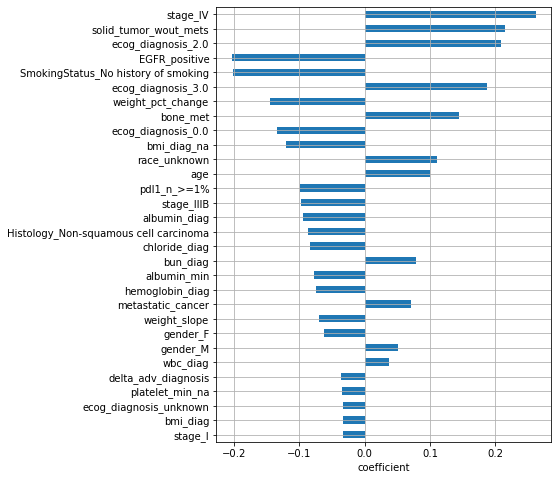

In [181]:
# Dataframe of coefficients for each variable 
coefficients_enet = pd.DataFrame(
    enet.named_steps['coxnetsurvivalanalysis'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_enet.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_enet.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

**Among the penalized Cox models, the ridge penalty has the best performance in regards to test set 1 year AUC. Not surprisingly, the penalized Cox models perform worse than the gradient boosting model or the random survival forest.**

## 5. Linear survival support vector machine 

**Lastly, we'll build a survival support vector machines with a linear kernel and a ranking objective.** 

In [182]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline

from sksurv.svm import FastSurvivalSVM
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

import warnings 

import matplotlib.pyplot as plt

In [183]:
pipe = make_pipeline(preprocessor_red, FastSurvivalSVM(rank_ratio = 1, 
                                                       max_iter = 1000, 
                                                       tol = 1e-3,
                                                       random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__fastsurvivalsvm__alpha': 10. ** np.linspace(-3, 3, 15)}

linear_svm_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 365),
    param_grid = param_grid,
    cv = cv,
    error_score = 0.5,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
linear_svm_search.fit(train90_x_red, train90_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                  

In [184]:
linear_svm_search.best_params_

{'estimator__fastsurvivalsvm__alpha': 19.306977288832496}

In [185]:
best_linear_svm_alpha = linear_svm_search.best_params_.get('estimator__fastsurvivalsvm__alpha')

In [186]:
linear_svm = make_pipeline(preprocessor_red, FastSurvivalSVM(alpha = best_linear_svm_alpha,
                                                             rank_ratio = 1,
                                                             max_iter = 1000,
                                                             tol = 1e-3,
                                                             random_state = 42))

linear_svm.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                            

In [187]:
linear_svm_risk_scores_te = linear_svm.predict(test_x_red)
linear_svm_auc_te = cumulative_dynamic_auc(train_y, test_y, linear_svm_risk_scores_te, 365)[0][0]
print('Test set AUC at 1 year:', linear_svm_auc_te)

Test set AUC at 1 year: 0.7463586500149999


In [188]:
linear_svm_risk_scores_tr = linear_svm.predict(train_x_red)
linear_svm_auc_tr = cumulative_dynamic_auc(train_y, train_y, linear_svm_risk_scores_tr, 365)[0][0]
print('Training set AUC at 1 year:', linear_svm_auc_tr)

Training set AUC at 1 year: 0.7510827289322517


In [189]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

warnings.filterwarnings('ignore')

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(linear_svm_risk_scores_te), len(linear_svm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], linear_svm_risk_scores_te[indices], 365)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [190]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.004484023523094138


In [191]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

warnings.filterwarnings('ignore')

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(linear_svm_risk_scores_tr), len(linear_svm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], linear_svm_risk_scores_tr[indices], 365)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [192]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.002175740035390034


In [193]:
crude_auc_data = {'model': 'linear_svm_crude',
                  'auc_1yr_te': linear_svm_auc_te,
                  'sem_te': standard_error_te,
                  'auc_1yr_tr': linear_svm_auc_tr,
                  'sem_tr': standard_error_tr}

In [194]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [195]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [196]:
crude_auc_df.sort_values(by = 'auc_1yr_te', ascending = False)

,model,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,gbm_crude,0.787443,0.004128,0.793450,0.002031
1,rsf_crude,0.774594,0.004214,0.901029,0.001352
2,ridge_crude,0.751794,0.004430,0.755288,0.002165
5,linear_svm_crude,0.746359,0.004484,0.751083,0.002176
3,lasso_crude,0.736107,0.004536,0.737436,0.002255
4,enet_crude,0.735788,0.004540,0.737163,0.002255


In [197]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [198]:
times = np.arange(30, 1810, 30)
crude_linear_svm_auc_over5 = cumulative_dynamic_auc(train_y, test_y, linear_svm_risk_scores_te, times)[0]

times_data = {}
values = crude_linear_svm_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_linear_svm_over5_df = pd.DataFrame(times_data, index = ['linear_svm_crude'])

In [199]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [200]:
crude_auc_over5 = crude_auc_over5.append(crude_linear_svm_over5_df, ignore_index = False)

In [201]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.828087,0.837199,0.828516,0.822428,0.819805,0.812663,0.805503,0.801027,0.794772,0.791386,...,0.754921,0.755207,0.755186,0.753519,0.754502,0.755006,0.757776,0.757342,0.755963,0.760696
rsf_crude,0.867312,0.859772,0.835875,0.820824,0.812596,0.802378,0.794869,0.789264,0.781928,0.778615,...,0.749314,0.749701,0.748179,0.744339,0.745877,0.746235,0.748660,0.747506,0.745445,0.751312
ridge_crude,0.777286,0.780309,0.769720,0.763561,0.762762,0.760119,0.758587,0.756088,0.753052,0.752842,...,0.731014,0.730098,0.729564,0.728929,0.731563,0.731050,0.730840,0.729901,0.726485,0.729286
lasso_crude,0.768503,0.769596,0.761076,0.753053,0.750823,0.747141,0.744786,0.741996,0.737649,0.737079,...,0.741010,0.740091,0.739450,0.740001,0.742917,0.743656,0.744641,0.743439,0.738617,0.743433
enet_crude,0.768369,0.769453,0.760871,0.752795,0.750506,0.746809,0.744442,0.741660,0.737306,0.736737,...,0.741023,0.740099,0.739453,0.739998,0.742919,0.743656,0.744617,0.743423,0.738587,0.743444
linear_svm_crude,0.794071,0.797037,0.780634,0.767898,0.762944,0.757599,0.754273,0.751695,0.747845,0.747538,...,0.732331,0.731474,0.730943,0.731278,0.733874,0.733694,0.733866,0.732819,0.729257,0.731510


In [202]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [203]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names_out(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 192
Number of non-zero features in final model: 192


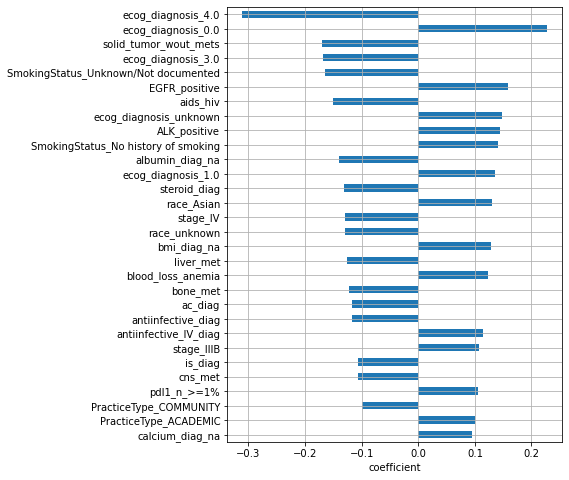

In [204]:
# Dataframe of coefficients for each variable 
coefficients_linear_svm = pd.DataFrame(
    linear_svm.named_steps['fastsurvivalsvm'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_linear_svm.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_linear_svm.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

**In conclusion, the gradient boosting model has the best test set performance in regards to 1 year AUC. Random survival forest follows closely behind. The bottom performers are penalized Cox and linear survival support vector machine.** 